# Модуль 11. **Рекурентні нейронні мережі** 
_Підбір параметрів_

In [58]:
import copy

import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Bidirectional,
    LSTM,
    GRU,
    SimpleRNN,
    Dense,
    GlobalMaxPool1D,
    Dropout,
)
import pandas as pd

     Загальні параметри для тренування моделей 

In [59]:
# керування виводом даних
verbose = 1
summary = False


# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 8,
    "skip_top": 10,
    "batch_size": 16,
    "dropout_rate": 0.0,
    "loss_function": "binary_crossentropy",
    "optimizer": "rmsprop",
    "hidden_units": 128,
    "activation": "sigmoid",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "epochs": [5, 6, 7, 8],
    # "epochs": [10, 20, 50, 100],
    "batch_size": [16, 32, 64],
    # "batch_size": [8, 32, 64, 128, 256],
    # "dropout_rate": [0.1, 0.2],
    "dropout_rate": [0.0, 0.05, 0.1, 0.2, 0.3],
    "loss_function": [
        # "sparse_categorical_crossentropy",
        "binary_crossentropy",
        # "mean_squared_error",
    ],
    "optimizer": ["adamw", "rmsprop"],
    # "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],
    # "hidden_units": [64, 128, 256],
    "hidden_units": [32, 64, 128, 256],
    "activation": ["relu", "sigmoid"],
    # "activation": ["relu", "sigmoid", "tanh"],
    "skip_top": [5, 6, 7, 8, 9, 10, 11, 12],
    "metrics": [
        "accuracy",
    ],
}

In [60]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
CYAN = "\033[36m"
RESET = "\033[0m"

### Завдання



### Допоміжні функції

    Функція друку поточних параметрів
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [61]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [62]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

     Функція завантаження даних 

In [63]:
def load_data(skip_top, max_features=10000, maxlen=500, verbose=0):
    # Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів
    (input_train, y_train), (input_test, y_test) = imdb.load_data(
        num_words=max_features, skip_top=skip_top
    )
    # Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів
    input_train = pad_sequences(input_train, maxlen=maxlen)
    input_test = pad_sequences(input_test, maxlen=maxlen)

    if verbose:
        print(f"{input_train.shape = },     {y_train.shape = }")
        print(f" {input_test.shape = },      {y_test.shape = }")
        print('-'*50)
    return input_train, y_train, input_test, y_test

    Функція підготовки моделі
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [64]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

    Функція тренування моделі
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [65]:
def train_model(
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    skip_top,
    verbose=0,
    summary=0,
):

    train_images, train_labels, test_images, test_labels = load_data(skip_top, verbose=verbose)

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, ' . ', CYAN, train_loss, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, ' . ', CYAN, test_loss, RESET)

    return history, test_acc

     Функція пошуку оптимальних параметрів 

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [66]:
def find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_func,
    verbose=0,
    summary=False,
):

    best_accuracy = 0.0
    best_parameters = {}

    if verbose:
        print_parameters(optimal_parameters)

    for param in study_sequence:

        print(f"{GRAY_BACK}{'=' * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{'=' * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                model_func,
                verbose=verbose,
                summary=summary,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

***
### **Модель для тренування 1** 
***

In [69]:
def model_1(hidden_units, activation, dropout_rate, max_features=10000):

    title_lstm = "Long Short-Term Memory (LSTM)"

    model_lstm = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_lstm.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_lstm.add(LSTM(32))
    model_lstm.add(Dropout(dropout_rate))
    model_lstm.add(Dense(1, activation=activation))

    return model_lstm

    Параметри, для навчання моделі 1
###### study_sequence - Послідовність дослідження

In [70]:
study_sequence = [
    "skip_top",
    "dropout_rate",
    "batch_size",
    # "hidden_units",
    # "loss_function",
    "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

    Пошук оптимальних параметрів для вказаної моделі 
###### model_1 - функція що досліджується

Поточні параметри:
 epochs 	= 8
 skip_top 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
Пошук оптимального значення параметра: skip_top 
--------------------------------------------------
Тестується значення: skip_top = 5
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 78ms/step - accuracy: 0.7268 - loss: 0.5228 - val_accuracy: 0.8668 - val_loss: 0.3192
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.8811 - loss: 0.3003 - val_accuracy: 0.8846 - val_loss: 0.2879
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.9002 - loss: 0.2574 - val_accuracy: 0.8806 - val_loss: 0.2855
Epoch 4/8
1563/1563 ━━━━━━

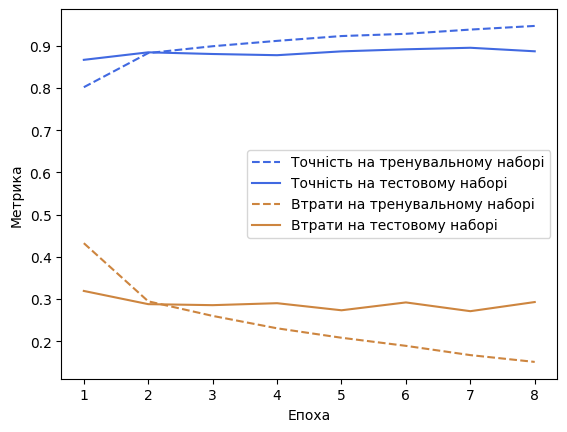

--------------------------------------------------
Тестується значення: skip_top = 6
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 99ms/step - accuracy: 0.7127 - loss: 0.5310 - val_accuracy: 0.8448 - val_loss: 0.3738
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 93ms/step - accuracy: 0.8756 - loss: 0.3037 - val_accuracy: 0.8821 - val_loss: 0.2926
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.8955 - loss: 0.2654 - val_accuracy: 0.8748 - val_loss: 0.3303
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.9083 - loss: 0.2414 - val_accuracy: 0.8813 - val_loss: 0.2900
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 92ms/step - accuracy: 0.9196 - loss: 0.2071 - val_accuracy: 0.8890 - val_loss: 0.2698
Epoch 6/8
1563/1563 ━━━━━━━

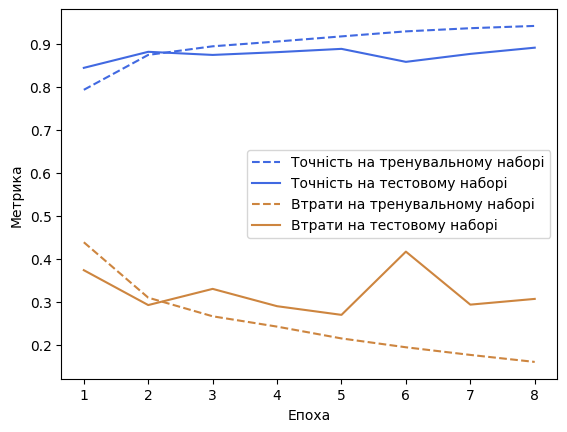

--------------------------------------------------
Тестується значення: skip_top = 7
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 100ms/step - accuracy: 0.7183 - loss: 0.5352 - val_accuracy: 0.8298 - val_loss: 0.3777
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.8675 - loss: 0.3280 - val_accuracy: 0.8784 - val_loss: 0.3019
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.8921 - loss: 0.2733 - val_accuracy: 0.8638 - val_loss: 0.3239
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.9094 - loss: 0.2386 - val_accuracy: 0.8762 - val_loss: 0.3112
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 100ms/step - accuracy: 0.9151 - loss: 0.2207 - val_accuracy: 0.8895 - val_loss: 0.2685
Epoch 6/8
1563/1563 ━━━━━

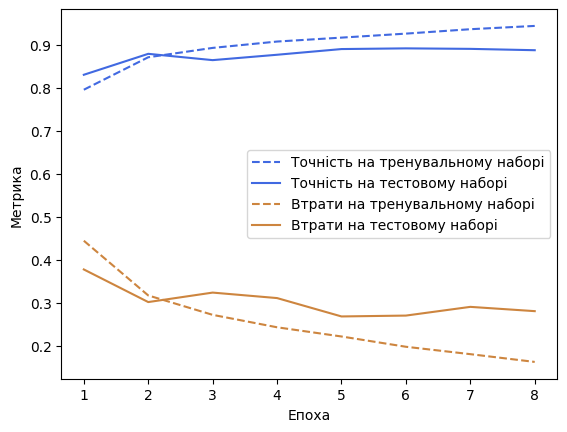

--------------------------------------------------
Тестується значення: skip_top = 8
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 99ms/step - accuracy: 0.7069 - loss: 0.5427 - val_accuracy: 0.8765 - val_loss: 0.3083
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.8734 - loss: 0.3181 - val_accuracy: 0.8765 - val_loss: 0.3004
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.8894 - loss: 0.2730 - val_accuracy: 0.8763 - val_loss: 0.3142
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 154s 99ms/step - accuracy: 0.9100 - loss: 0.2391 - val_accuracy: 0.8858 - val_loss: 0.2994
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 0.9216 - loss: 0.2103 - val_accuracy: 0.8205 - val_loss: 0.3865
Epoch 6/8
1563/1563 ━━━━━━━

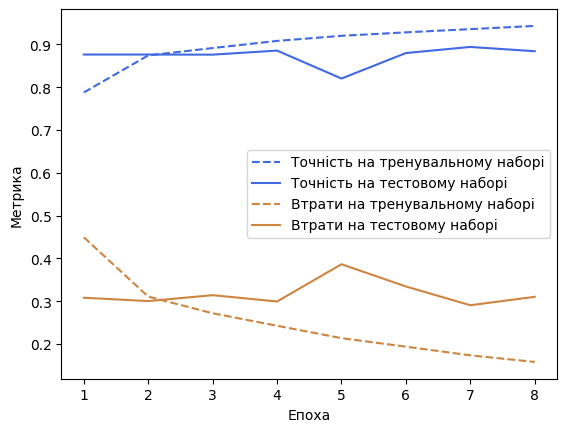

--------------------------------------------------
Тестується значення: skip_top = 9
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 101ms/step - accuracy: 0.6949 - loss: 0.5501 - val_accuracy: 0.8676 - val_loss: 0.3276
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.8703 - loss: 0.3235 - val_accuracy: 0.8115 - val_loss: 0.4593
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.8956 - loss: 0.2639 - val_accuracy: 0.8894 - val_loss: 0.2788
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.9138 - loss: 0.2256 - val_accuracy: 0.8818 - val_loss: 0.3157
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.9284 - loss: 0.1942 - val_accuracy: 0.8860 - val_loss: 0.3016
Epoch 6/8
1563/1563 ━━━━━

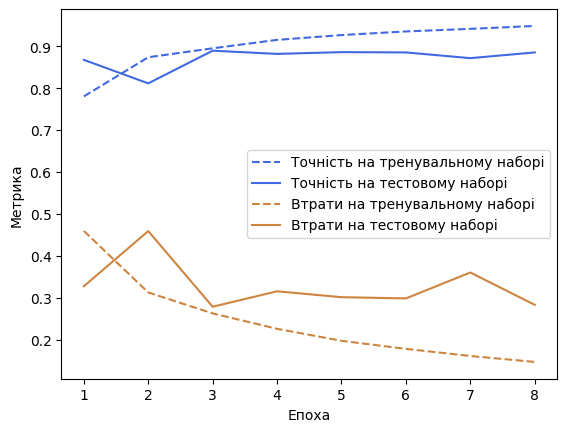

--------------------------------------------------
Тестується значення: skip_top = 10
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 99ms/step - accuracy: 0.7113 - loss: 0.5420 - val_accuracy: 0.8702 - val_loss: 0.3262
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.8734 - loss: 0.3136 - val_accuracy: 0.8623 - val_loss: 0.3425
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - accuracy: 0.8970 - loss: 0.2645 - val_accuracy: 0.8397 - val_loss: 0.3592
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.9111 - loss: 0.2368 - val_accuracy: 0.8661 - val_loss: 0.3362
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 153s 98ms/step - accuracy: 0.9230 - loss: 0.2019 - val_accuracy: 0.8873 - val_loss: 0.2961
Epoch 6/8
1563/1563 ━━━━━━

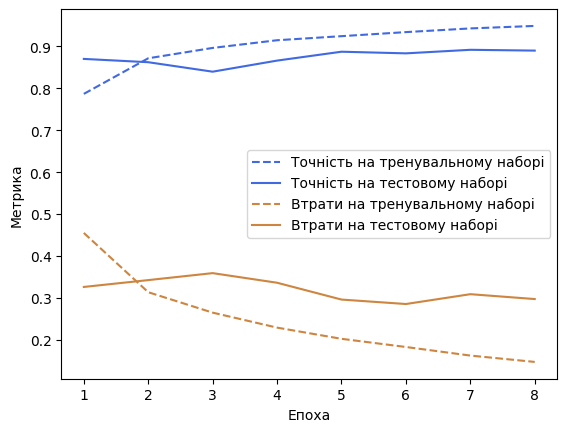

--------------------------------------------------
Тестується значення: skip_top = 11
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.7052 - loss: 0.5452 - val_accuracy: 0.8491 - val_loss: 0.3501
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.8682 - loss: 0.3214 - val_accuracy: 0.8732 - val_loss: 0.3032
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - accuracy: 0.8901 - loss: 0.2787 - val_accuracy: 0.8698 - val_loss: 0.3114
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - accuracy: 0.9108 - loss: 0.2346 - val_accuracy: 0.8858 - val_loss: 0.2768
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 88ms/step - accuracy: 0.9223 - loss: 0.2123 - val_accuracy: 0.8751 - val_loss: 0.3070
Epoch 6/8
1563/1563 ━━━━━

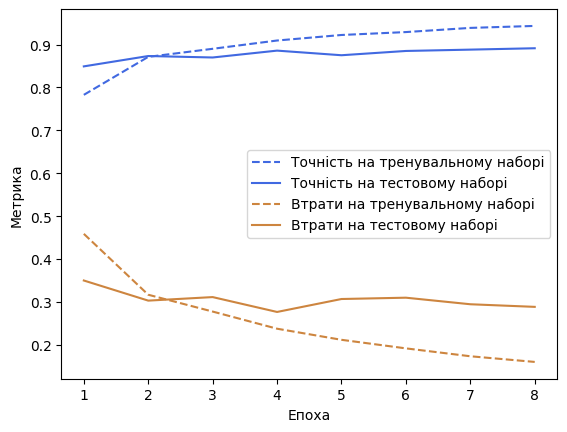

--------------------------------------------------
Тестується значення: skip_top = 12
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - accuracy: 0.6948 - loss: 0.5511 - val_accuracy: 0.8320 - val_loss: 0.3838
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - accuracy: 0.8647 - loss: 0.3311 - val_accuracy: 0.8744 - val_loss: 0.3026
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.8948 - loss: 0.2715 - val_accuracy: 0.8774 - val_loss: 0.3177
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - accuracy: 0.9043 - loss: 0.2438 - val_accuracy: 0.8813 - val_loss: 0.3147
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - accuracy: 0.9219 - loss: 0.2101 - val_accuracy: 0.8644 - val_loss: 0.3461
Epoch 6/8
1563/1563 ━━━━━━

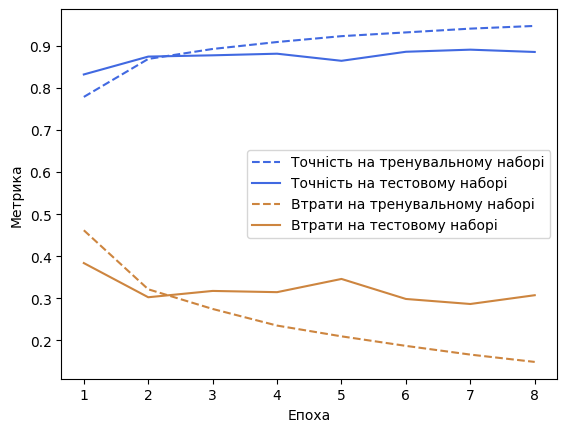

 Оптимальне значення параметра skip_top = 6
   точність на тестових даних: 0.8917199969291687

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 84ms/step - accuracy: 0.7099 - loss: 0.5357 - val_accuracy: 0.8633 - val_loss: 0.3348
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.8745 - loss: 0.3088 - val_accuracy: 0.8121 - val_loss: 0.4121
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.8981 - loss: 0.2668 - val_accuracy: 0.8194 - val_loss: 0.4746
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.9058 - loss: 0.2407 - val_accuracy: 0.8893 - val_loss: 0.2904
Epoch

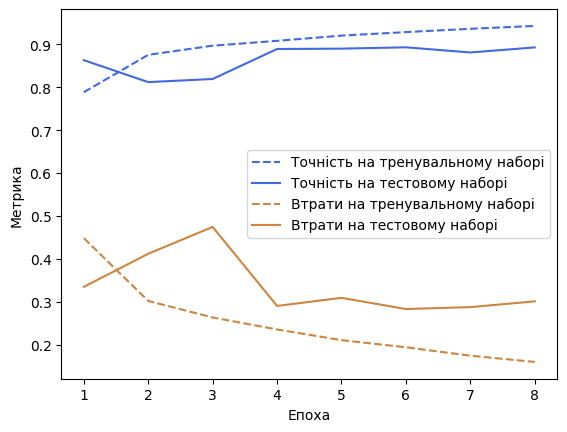

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.7172 - loss: 0.5294 - val_accuracy: 0.8654 - val_loss: 0.3307
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.8834 - loss: 0.3010 - val_accuracy: 0.8865 - val_loss: 0.2807
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - accuracy: 0.8964 - loss: 0.2632 - val_accuracy: 0.8881 - val_loss: 0.2767
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.9106 - loss: 0.2364 - val_accuracy: 0.8866 - val_loss: 0.2764
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 88ms/step - accuracy: 0.9246 - loss: 0.2077 - val_accuracy: 0.8906 - val_loss: 0.2788
Epoch 6/8
1563/1563 ━

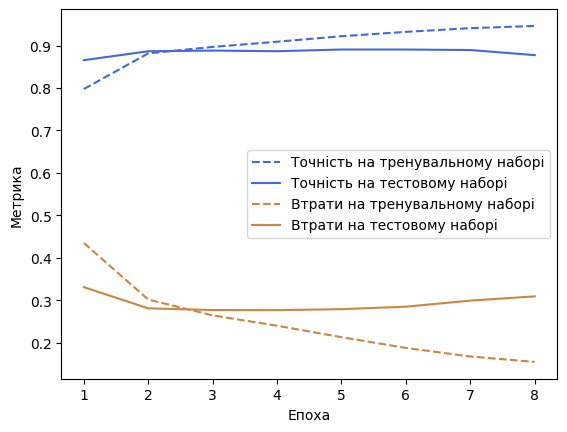

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 91ms/step - accuracy: 0.7092 - loss: 0.5366 - val_accuracy: 0.8737 - val_loss: 0.3067
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.8791 - loss: 0.3060 - val_accuracy: 0.8836 - val_loss: 0.2845
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.9004 - loss: 0.2597 - val_accuracy: 0.8815 - val_loss: 0.3098
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - accuracy: 0.9140 - loss: 0.2281 - val_accuracy: 0.8726 - val_loss: 0.3300
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - accuracy: 0.9258 - loss: 0.2090 - val_accuracy: 0.8866 - val_loss: 0.3203
Epoch 6/8
1563/1563 ━

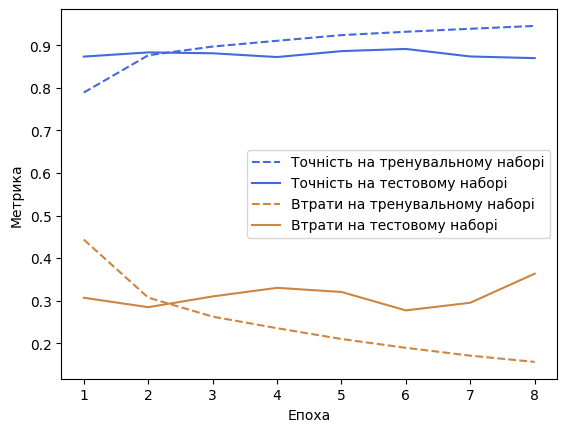

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 88ms/step - accuracy: 0.7065 - loss: 0.5380 - val_accuracy: 0.8630 - val_loss: 0.3239
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - accuracy: 0.8810 - loss: 0.3096 - val_accuracy: 0.8807 - val_loss: 0.2857
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.8944 - loss: 0.2735 - val_accuracy: 0.8588 - val_loss: 0.4332
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 84ms/step - accuracy: 0.9145 - loss: 0.2309 - val_accuracy: 0.8859 - val_loss: 0.2813
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 87ms/step - accuracy: 0.9234 - loss: 0.2143 - val_accuracy: 0.8869 - val_loss: 0.2793
Epoch 6/8
1563/1563 ━

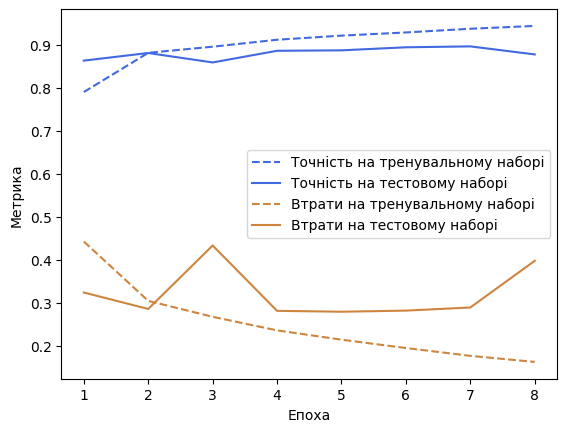

 Оптимальне значення параметра dropout_rate = 0.0
   точність на тестових даних: 0.8930000066757202

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 16
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 134s 85ms/step - accuracy: 0.7183 - loss: 0.5284 - val_accuracy: 0.8704 - val_loss: 0.3131
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.8780 - loss: 0.3026 - val_accuracy: 0.7348 - val_loss: 0.7903
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - accuracy: 0.8980 - loss: 0.2628 - val_accuracy: 0.8736 - val_loss: 0.2959
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - accuracy: 0.9120 - loss: 0.2332 - val_accuracy: 0.8840 - val_loss: 0.2912
Epoc

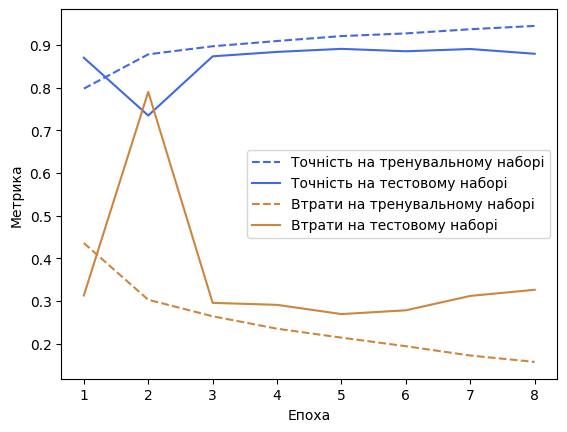

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 102ms/step - accuracy: 0.6888 - loss: 0.5633 - val_accuracy: 0.8377 - val_loss: 0.3742
Epoch 2/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.8649 - loss: 0.3326 - val_accuracy: 0.8798 - val_loss: 0.2904
Epoch 3/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.8906 - loss: 0.2749 - val_accuracy: 0.8790 - val_loss: 0.3030
Epoch 4/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step - accuracy: 0.9125 - loss: 0.2309 - val_accuracy: 0.7814 - val_loss: 0.6925
Epoch 5/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.9221 - loss: 0.2105 - val_accuracy: 0.8868 - val_loss: 0.2847
Epoch 6/8
782/782 ━━━━━━━━━━━━━━━━

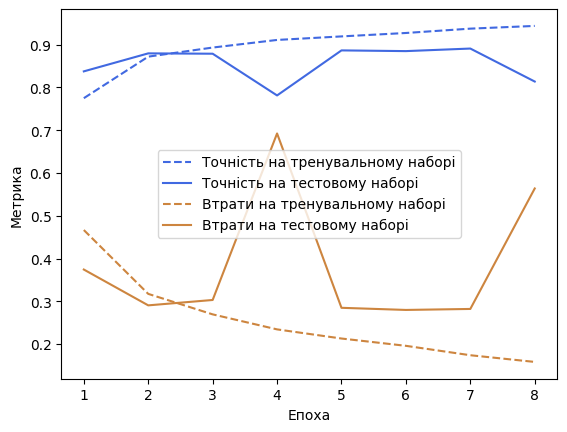

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/step - accuracy: 0.6310 - loss: 0.6178 - val_accuracy: 0.8446 - val_loss: 0.3617
Epoch 2/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - accuracy: 0.8553 - loss: 0.3537 - val_accuracy: 0.8483 - val_loss: 0.3557
Epoch 3/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 147ms/step - accuracy: 0.8813 - loss: 0.2965 - val_accuracy: 0.8664 - val_loss: 0.3223
Epoch 4/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 140ms/step - accuracy: 0.9018 - loss: 0.2519 - val_accuracy: 0.8495 - val_loss: 0.4220
Epoch 5/8
391/391 ━━━━━━━━━━━━━━━━━━━━ 61s 155ms/step - accuracy: 0.9122 - loss: 0.2342 - val_accuracy: 0.8848 - val_loss: 0.3056
Epoch 6/8
391/391 ━━━━━━━━━━━━━━━━

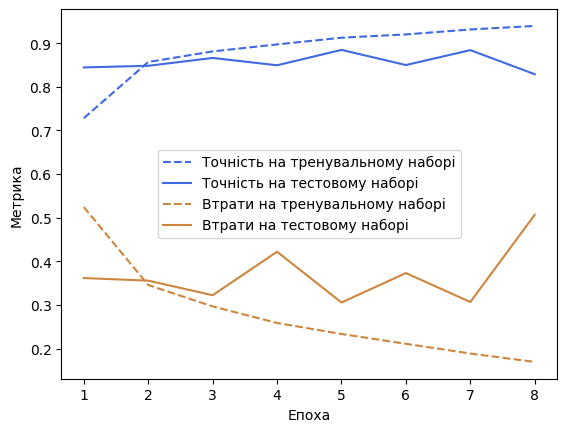

 Оптимальне значення параметра batch_size = 16
   точність на тестових даних: 0.8930000066757202

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adamw
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - accuracy: 0.7313 - loss: 0.5199 - val_accuracy: 0.7646 - val_loss: 0.4967
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.8184 - loss: 0.4144 - val_accuracy: 0.6961 - val_loss: 0.5639
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 134s 85ms/step - accuracy: 0.8271 - loss: 0.3858 - val_accuracy: 0.8424 - val_loss: 0.3699
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 83ms/step - accuracy: 0.8888 - loss: 0.2824 - val_accuracy: 0.8562 - val_loss: 0.3454
Epoch 

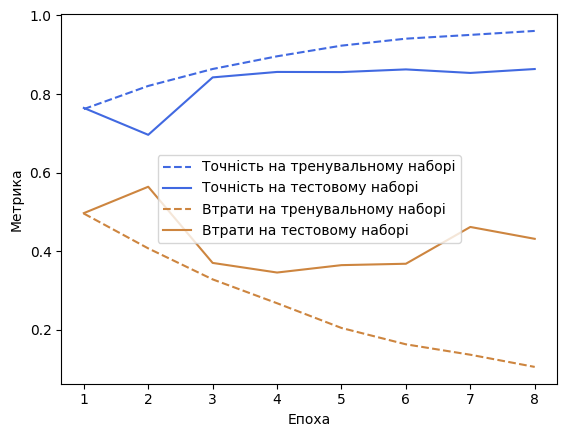

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 83ms/step - accuracy: 0.7165 - loss: 0.5275 - val_accuracy: 0.8429 - val_loss: 0.3595
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.8808 - loss: 0.3046 - val_accuracy: 0.8510 - val_loss: 0.3513
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - accuracy: 0.8981 - loss: 0.2617 - val_accuracy: 0.8648 - val_loss: 0.3057
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 102ms/step - accuracy: 0.9128 - loss: 0.2292 - val_accuracy: 0.8225 - val_loss: 0.4661
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.9267 - loss: 0.1959 - val_accuracy: 0.8846 - val_loss: 0.2778
Epoch 6/8
1563/1563

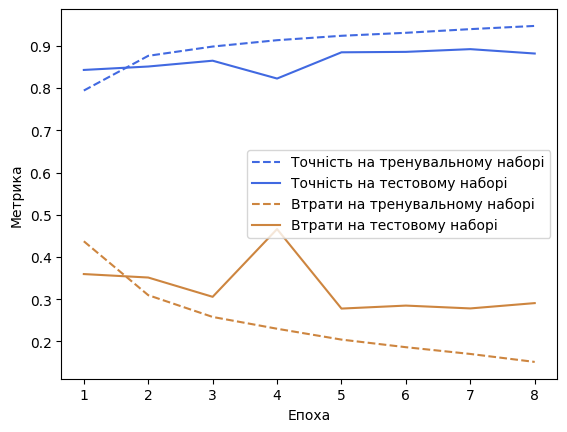

 Оптимальне значення параметра optimizer = rmsprop
   точність на тестових даних: 0.8930000066757202

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 5
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.7155 - loss: 0.5305 - val_accuracy: 0.8653 - val_loss: 0.3791
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - accuracy: 0.8813 - loss: 0.3047 - val_accuracy: 0.8755 - val_loss: 0.3016
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 79ms/step - accuracy: 0.9026 - loss: 0.2602 - val_accuracy: 0.8384 - val_loss: 0.3683
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.9120 - loss: 0.2289 - val_accuracy: 0.8619 - val_loss: 0.3711
Epoch 5/5
15

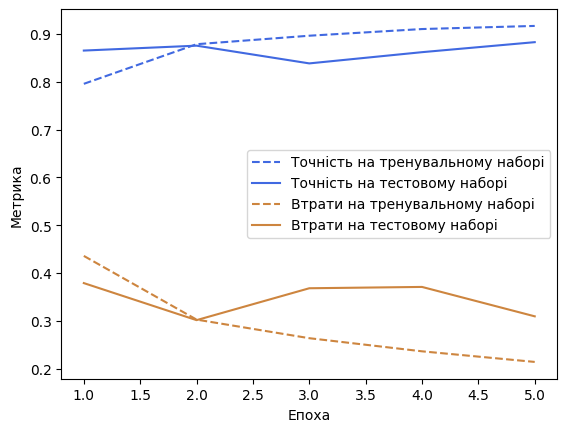

--------------------------------------------------
Тестується значення: epochs = 6
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 129s 82ms/step - accuracy: 0.7122 - loss: 0.5293 - val_accuracy: 0.8486 - val_loss: 0.3595
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.8779 - loss: 0.3116 - val_accuracy: 0.8680 - val_loss: 0.3163
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 81ms/step - accuracy: 0.8981 - loss: 0.2680 - val_accuracy: 0.8852 - val_loss: 0.2812
Epoch 4/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.9108 - loss: 0.2366 - val_accuracy: 0.8753 - val_loss: 0.3444
Epoch 5/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 82ms/step - accuracy: 0.9210 - loss: 0.2120 - val_accuracy: 0.8812 - val_loss: 0.3150
Epoch 6/6
1563/1563 ━━━━━━━━━

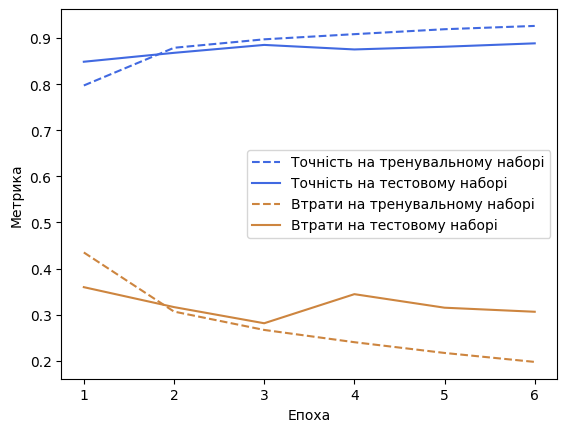

--------------------------------------------------
Тестується значення: epochs = 7
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 84ms/step - accuracy: 0.7064 - loss: 0.5390 - val_accuracy: 0.8476 - val_loss: 0.3627
Epoch 2/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 129s 82ms/step - accuracy: 0.8769 - loss: 0.3068 - val_accuracy: 0.8580 - val_loss: 0.3533
Epoch 3/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.8974 - loss: 0.2656 - val_accuracy: 0.8820 - val_loss: 0.3059
Epoch 4/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.9077 - loss: 0.2402 - val_accuracy: 0.8892 - val_loss: 0.2747
Epoch 5/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.9215 - loss: 0.2105 - val_accuracy: 0.8765 - val_loss: 0.3339
Epoch 6/7
1563/1563 ━━━━━━━━━

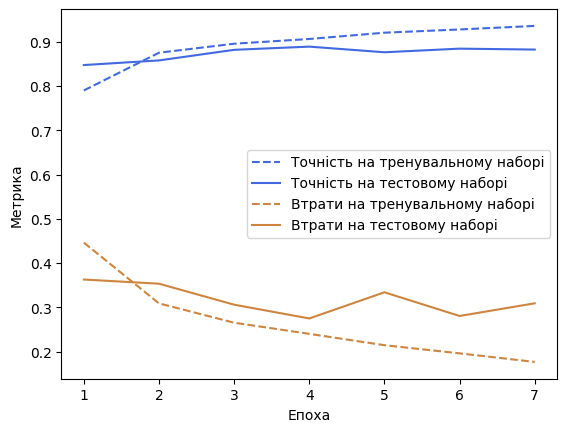

--------------------------------------------------
Тестується значення: epochs = 8
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 81ms/step - accuracy: 0.7140 - loss: 0.5282 - val_accuracy: 0.8246 - val_loss: 0.4528
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.8745 - loss: 0.3089 - val_accuracy: 0.8675 - val_loss: 0.3128
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 88ms/step - accuracy: 0.9017 - loss: 0.2567 - val_accuracy: 0.8628 - val_loss: 0.3303
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.9114 - loss: 0.2278 - val_accuracy: 0.8836 - val_loss: 0.2831
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - accuracy: 0.9212 - loss: 0.2086 - val_accuracy: 0.8938 - val_loss: 0.2644
Epoch 6/8
1563/1563 ━━━━━━━━━

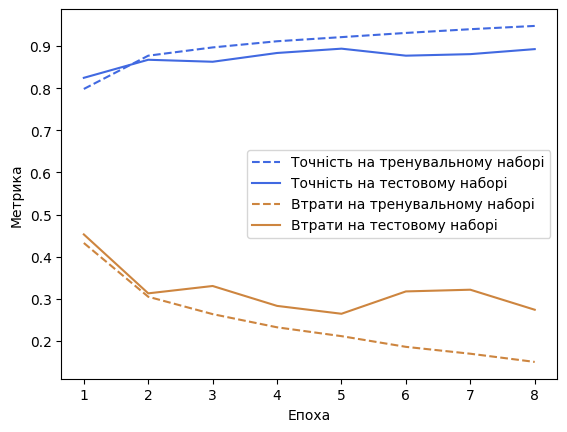

 Оптимальне значення параметра epochs = 8
   точність на тестових даних: 0.8930000066757202



In [71]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_1,
    verbose=verbose,
    summary=summary,
)

In [72]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_1
 epochs 	= 8
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8930000066757202


<div class="alert alert-block alert-info">
<b>Оптимальні параметри для model_1</b>
```
 epochs 	= 8
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8930000066757202
 ```
</div>

***
### **Модель для тренування 2** 
***


In [73]:
def model_2(hidden_units, activation, dropout_rate, max_features=10000):

    title_gru = "Gated Recurrent Unit (GRU)"

    model_gru = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_gru.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_gru.add(GRU(32))
    model_gru.add(Dropout(dropout_rate))
    model_gru.add(Dense(1, activation=activation))

    return model_gru

In [74]:
study_sequence = [
    # "batch_size",
    # "skip_top",
    "dropout_rate",
    # "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

Поточні параметри:
 epochs 	= 8
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 103ms/step - accuracy: 0.6848 - loss: 0.5583 - val_accuracy: 0.8669 - val_loss: 0.3199
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.8761 - loss: 0.3098 - val_accuracy: 0.8646 - val_loss: 0.3446
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 102ms/step - accuracy: 0.9075 - loss: 0.2456 - val_accuracy: 0.8723 - val_loss: 0.3019
Epoch 4/8
1563

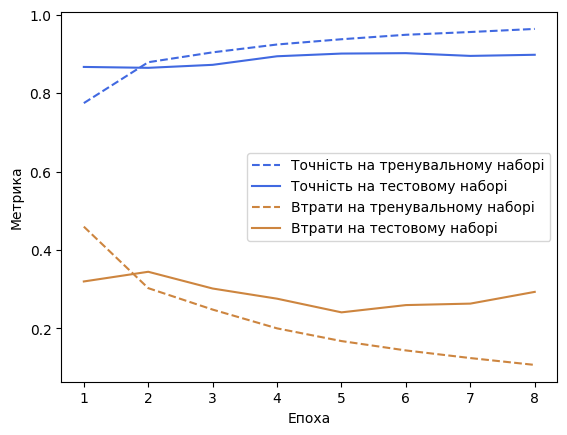

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 103ms/step - accuracy: 0.6792 - loss: 0.5593 - val_accuracy: 0.8463 - val_loss: 0.3595
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 102ms/step - accuracy: 0.8736 - loss: 0.3107 - val_accuracy: 0.8787 - val_loss: 0.2926
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 102ms/step - accuracy: 0.9076 - loss: 0.2409 - val_accuracy: 0.8980 - val_loss: 0.2482
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - accuracy: 0.9316 - loss: 0.1866 - val_accuracy: 0.9045 - val_loss: 0.2375
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.9447 - loss: 0.1530 - val_accuracy: 0.8917 - val_loss: 0.2727
Epoch 6/8
1563/15

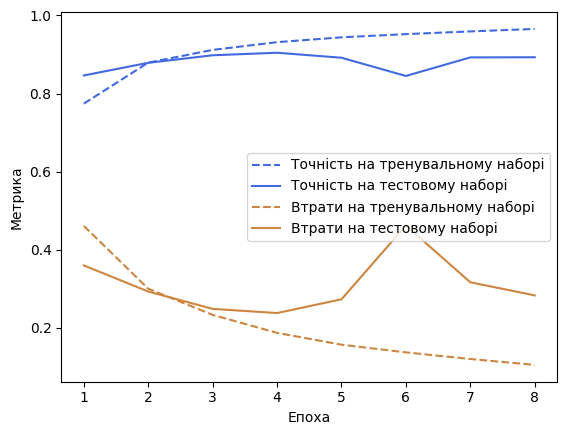

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 100ms/step - accuracy: 0.6767 - loss: 0.5582 - val_accuracy: 0.8023 - val_loss: 0.4832
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 102ms/step - accuracy: 0.8744 - loss: 0.3164 - val_accuracy: 0.8859 - val_loss: 0.2773
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 172s 110ms/step - accuracy: 0.9101 - loss: 0.2408 - val_accuracy: 0.8928 - val_loss: 0.2571
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 164s 105ms/step - accuracy: 0.9314 - loss: 0.1875 - val_accuracy: 0.8713 - val_loss: 0.3381
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 168s 108ms/step - accuracy: 0.9456 - loss: 0.1564 - val_accuracy: 0.8978 - val_loss: 0.2588
Epoch 6/8
1563/1

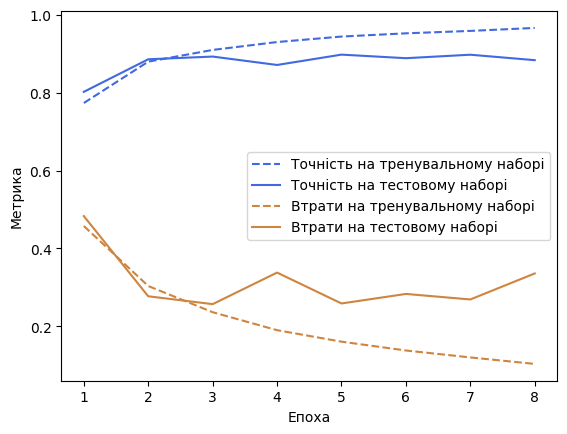

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 186s 118ms/step - accuracy: 0.6741 - loss: 0.5722 - val_accuracy: 0.8489 - val_loss: 0.3580
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 180s 115ms/step - accuracy: 0.8795 - loss: 0.3064 - val_accuracy: 0.8768 - val_loss: 0.2923
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 186s 119ms/step - accuracy: 0.9131 - loss: 0.2303 - val_accuracy: 0.8998 - val_loss: 0.2489
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - accuracy: 0.9327 - loss: 0.1805 - val_accuracy: 0.8719 - val_loss: 0.3634
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 184s 118ms/step - accuracy: 0.9458 - loss: 0.1510 - val_accuracy: 0.9023 - val_loss: 0.2579
Epoch 6/8
1563/1

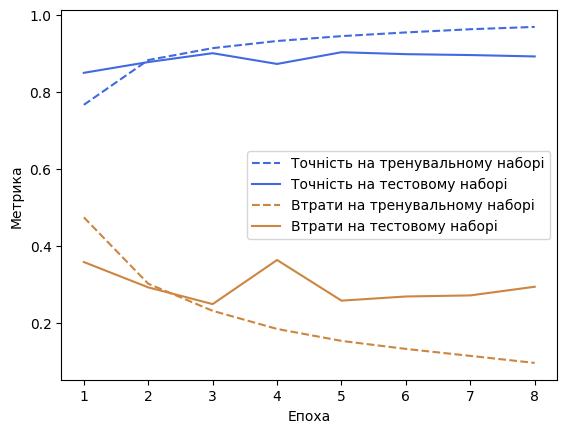

 Оптимальне значення параметра dropout_rate = 0.0
   точність на тестових даних: 0.8979200124740601

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 5
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 186s 118ms/step - accuracy: 0.6858 - loss: 0.5547 - val_accuracy: 0.6807 - val_loss: 0.8127
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 184s 118ms/step - accuracy: 0.8750 - loss: 0.3118 - val_accuracy: 0.8792 - val_loss: 0.2930
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - accuracy: 0.9081 - loss: 0.2392 - val_accuracy: 0.8955 - val_loss: 0.2743
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 179s 114ms/step - accuracy: 0.9286 - loss: 0.1894 - val_accuracy: 0.8968 - val_loss: 0.2609
Epoch 5/5

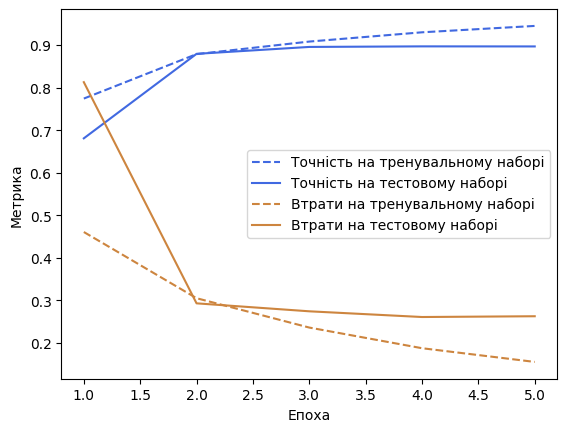

--------------------------------------------------
Тестується значення: epochs = 6
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 182s 115ms/step - accuracy: 0.6916 - loss: 0.5537 - val_accuracy: 0.8453 - val_loss: 0.3630
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 177s 113ms/step - accuracy: 0.8788 - loss: 0.3048 - val_accuracy: 0.8658 - val_loss: 0.3246
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - accuracy: 0.9128 - loss: 0.2293 - val_accuracy: 0.8988 - val_loss: 0.2474
Epoch 4/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 180s 115ms/step - accuracy: 0.9334 - loss: 0.1840 - val_accuracy: 0.8628 - val_loss: 0.3477
Epoch 5/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 175s 112ms/step - accuracy: 0.9443 - loss: 0.1520 - val_accuracy: 0.8994 - val_loss: 0.2550
Epoch 6/6
1563/1563 ━━━━

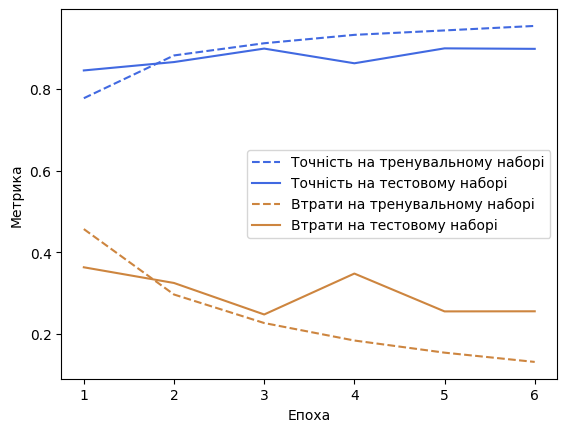

--------------------------------------------------
Тестується значення: epochs = 7
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 168s 107ms/step - accuracy: 0.6885 - loss: 0.5506 - val_accuracy: 0.8475 - val_loss: 0.3561
Epoch 2/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 182s 116ms/step - accuracy: 0.8730 - loss: 0.3141 - val_accuracy: 0.8690 - val_loss: 0.3556
Epoch 3/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 195s 125ms/step - accuracy: 0.9108 - loss: 0.2324 - val_accuracy: 0.8979 - val_loss: 0.2561
Epoch 4/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 190s 121ms/step - accuracy: 0.9313 - loss: 0.1890 - val_accuracy: 0.8979 - val_loss: 0.2508
Epoch 5/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 189s 121ms/step - accuracy: 0.9426 - loss: 0.1614 - val_accuracy: 0.9031 - val_loss: 0.2427
Epoch 6/7
1563/1563 ━━━━

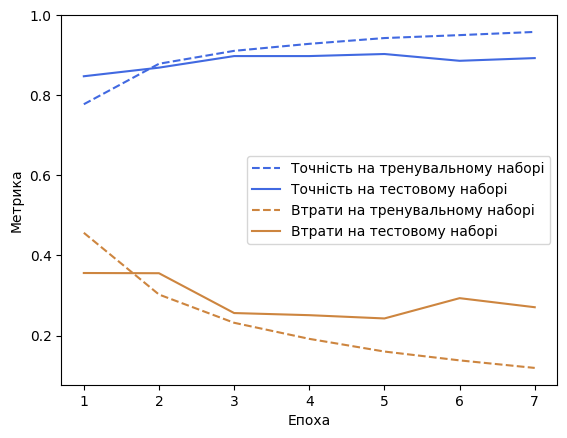

--------------------------------------------------
Тестується значення: epochs = 8
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 193s 123ms/step - accuracy: 0.6930 - loss: 0.5470 - val_accuracy: 0.8270 - val_loss: 0.4306
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 190s 122ms/step - accuracy: 0.8745 - loss: 0.3124 - val_accuracy: 0.8362 - val_loss: 0.4482
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 190s 122ms/step - accuracy: 0.9034 - loss: 0.2493 - val_accuracy: 0.8941 - val_loss: 0.2610
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - accuracy: 0.9270 - loss: 0.1927 - val_accuracy: 0.8992 - val_loss: 0.2463
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 183s 117ms/step - accuracy: 0.9436 - loss: 0.1579 - val_accuracy: 0.8990 - val_loss: 0.2537
Epoch 6/8
1563/1563 ━━━━

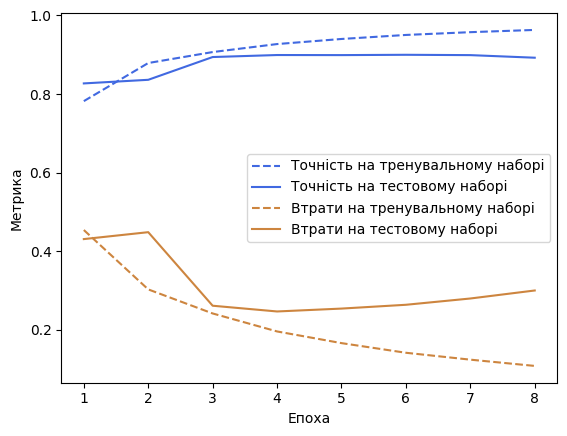

 Оптимальне значення параметра epochs = 6
   точність на тестових даних: 0.8981599807739258



In [75]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_2,
    verbose=1,
)

In [76]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_2
 epochs 	= 6
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8981599807739258


<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 

```
Оптимальні параметри для model_2
 epochs 	= 6
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8981599807739258
 ```
</div>

***
### **Модель для тренування 3** 
***

In [77]:
def model_3(hidden_units, activation, dropout_rate, max_features=10000):

    title_drnn = "Deep Recurrent Neural Network + LSTM (DRNN)"

    model_drnn = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_drnn.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_drnn.add(Bidirectional(LSTM(32, return_sequences=True)))
    model_drnn.add(Dropout(dropout_rate))
    model_drnn.add(Bidirectional(LSTM(32)))
    model_drnn.add(Dense(1, activation=activation))

    return model_drnn

In [ ]:
study_sequence = [
    # "batch_size",
    # "skip_top",
    "dropout_rate",
    # "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

Поточні параметри:
 epochs 	= 6
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 426s 270ms/step - accuracy: 0.6783 - loss: 0.5505 - val_accuracy: 0.8136 - val_loss: 0.4191
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 435s 278ms/step - accuracy: 0.8784 - loss: 0.3066 - val_accuracy: 0.8847 - val_loss: 0.2953
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 437s 280ms/step - accuracy: 0.9046 - loss: 0.2500 - val_accuracy: 0.8831 - val_loss: 0.2952
Epoch 4/6
1563

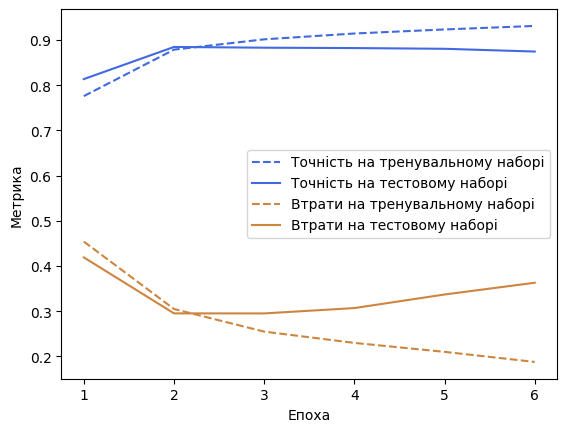

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 445s 282ms/step - accuracy: 0.6995 - loss: 0.5388 - val_accuracy: 0.7795 - val_loss: 0.5463
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 436s 279ms/step - accuracy: 0.8773 - loss: 0.3066 - val_accuracy: 0.8850 - val_loss: 0.2840
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 456s 292ms/step - accuracy: 0.8970 - loss: 0.2590 - val_accuracy: 0.8900 - val_loss: 0.2846
Epoch 4/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 405s 259ms/step - accuracy: 0.9163 - loss: 0.2270 - val_accuracy: 0.8883 - val_loss: 0.2756
Epoch 5/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9260 - loss: 0.2014

In [78]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_3,
    verbose=1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_3")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_3:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Спостерігається <b>невеличке покращення</b> роботи моделі після її ускладнення<br>
<b>Точність</b> на тестових даних змінилася з <b>89.68%</b> до <b>90.27%</b></p>
<p>Оптимальні параметри змінилися тільки в одному пункті: <br>
 - hidden_units було 256 стало 512</p>
</div>

***
### **Модель для тренування 4** 
***

In [ ]:
def model_4(hidden_units, activation, dropout_rate, max_features=10000):

    title_kgl = "From Kaggle"

    # embed_size = 128
    embed_size = hidden_units
    model_kgl = Sequential()
    model_kgl.add(Embedding(max_features, embed_size))
    model_kgl.add(Bidirectional(LSTM(32, return_sequences=True)))
    model_kgl.add(GlobalMaxPool1D())
    model_kgl.add(Dense(20, activation=activation))
    model_kgl.add(Dropout(dropout_rate))
    model_kgl.add(Dense(1, activation="sigmoid"))

    return model_kgl

In [ ]:
study_sequence = [
    # "batch_size",
    # "skip_top",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    "activation",
    # "metrics",
    "epochs",
]

In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_4,
    verbose=1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_4")
print(f" Точність:        {YELLOW}{best_accuracy}")